In [1]:
import torch.nn as nn
import numpy as np 
import pandas as pd 
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import os
import cv2
import tqdm.notebook as tq
import seaborn as sns
from sklearn.model_selection import KFold
from scipy.stats import mode
from sklearn.metrics import classification_report

DEBUG = True


In [2]:
images_path = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Training Data'
classes_names = ['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']

In [3]:
all_classes =  os.listdir(os.path.join(images_path))
all_images = os.listdir(os.path.join(images_path, 'Coast'))
len(all_images)

2000

In [4]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((200, 200)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((200, 200)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [5]:
images_path = '/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/'

train_dataset = torchvision.datasets.ImageFolder(os.path.join(images_path, 'Training Data'),
                                                train_transforms)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(images_path, 'Validation Data'),
                                                test_transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers= 2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers= 2)

In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.c_layers = nn.Sequential(
            nn.Conv2d(3, 16, 5, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 5, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16, 32, 5, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 32, 5, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32, 64, 5, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2), 
            nn.Conv2d(64, 64, 5, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2), 
        )
        self.n_layers = nn.Sequential(
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 5)
        )       
    def forward(self, x):
        out = self.c_layers(x)
        out = torch.flatten(out, start_dim=1)
        out = self.n_layers(out)
        return out

In [7]:
if DEBUG == True:
    model = Model()
    print(model(torch.randn(3,3,200,200)))
    del model

tensor([[ 0.2257,  0.1264, -0.3740, -0.1299, -0.7811],
        [-0.7697,  0.7383,  0.4411,  0.2669, -0.0627],
        [ 0.4054,  0.0133, -0.4553, -0.0189, -0.0318]],
       grad_fn=<AddmmBackward0>)


In [8]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 10
criterion = nn.CrossEntropyLoss().to(device)

In [9]:
def train(model, dataloader, criterion, opt, logger, epoch):
    model.train()
    
    train_acc = 0.0
    train_loss = 0.0
    
    for step, (images, labels) in tq.tqdm(enumerate(dataloader)):
        images, labels = images.to(device), labels.to(device)
        
        output = model(images)
        loss = criterion(output, labels)

        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()
        
        train_acc += torch.sum(torch.argmax(output, dim=1) == labels)
        train_loss += loss.item()
        
    logger['train_loss'].append(train_loss / step)
    logger['train_acc'].append(train_acc.detach().cpu().numpy() / len(train_sampler))
    
    print(f'Epoch: {epoch + 1}, train_loss: {train_loss / step}, train_acc: {train_acc/len(train_sampler):.3f}')


In [10]:
EPOCHS = 8
LR = 0.0001
wd = 0.01
max_lr = 0.01

In [11]:
def validate(model, dataloader, criterion, opt, logger, epoch):
    model.eval()
    
    eval_acc = 0.0
    eval_loss = 0.0
    
    with torch.no_grad():
        for step, (images, labels) in tq.tqdm(enumerate(dataloader)):
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            loss = criterion(output, labels)

            eval_acc += torch.sum(torch.argmax(output, dim=1) == labels)
            eval_loss += loss.item()
    
    logger['eval_loss'].append(eval_loss / step)
    logger['eval_acc'].append(eval_acc.detach().cpu().numpy() / len(val_sampler))
    
    print(f'Epoch: {epoch+ 1}, val_loss: {eval_loss / step}, eval_acc: {eval_acc/len(val_sampler):.3f}')


In [12]:
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)

train_logger = {'train_loss': [],
                'train_acc' : []}
eval_logger = {'eval_loss': [],
                'eval_acc' : []}

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(train_dataset)))):
    print('*' * 20)
    print('Fold {}'.format(fold + 1))
    print('*' * 20)
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=val_sampler)
    
    
    model = Model().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(opt,max_lr=max_lr, total_steps=int(EPOCHS * len(train_dataloader.dataset)* 0.8))
    for epoch in range(EPOCHS):
        train(model, train_loader, criterion, opt,train_logger, epoch)
        validate(model, val_loader, criterion, opt,eval_logger, epoch)
    torch.save(model.state_dict(), f'model_{fold}')
    del model

********************
Fold 1
********************


0it [00:00, ?it/s]

Epoch: 1, train_loss: 0.9136196398830797, train_acc: 0.650


0it [00:00, ?it/s]

Epoch: 1, val_loss: 0.7998503879193337, eval_acc: 0.705


0it [00:00, ?it/s]

Epoch: 2, train_loss: 0.7760373359942532, train_acc: 0.713


0it [00:00, ?it/s]

Epoch: 2, val_loss: 0.7938797315282207, eval_acc: 0.716


0it [00:00, ?it/s]

Epoch: 3, train_loss: 0.7232659895975427, train_acc: 0.733


0it [00:00, ?it/s]

Epoch: 3, val_loss: 0.7217938611584325, eval_acc: 0.746


0it [00:00, ?it/s]

Epoch: 4, train_loss: 0.7037873719351359, train_acc: 0.746


0it [00:00, ?it/s]

Epoch: 4, val_loss: 0.6933242899756278, eval_acc: 0.753


0it [00:00, ?it/s]

Epoch: 5, train_loss: 0.69154256773761, train_acc: 0.749


0it [00:00, ?it/s]

Epoch: 5, val_loss: 0.6869533292708858, eval_acc: 0.750


0it [00:00, ?it/s]

Epoch: 6, train_loss: 0.6664783448339945, train_acc: 0.764


0it [00:00, ?it/s]

Epoch: 6, val_loss: 0.9572857253013118, eval_acc: 0.645


0it [00:00, ?it/s]

Epoch: 7, train_loss: 0.6608529433189146, train_acc: 0.770


0it [00:00, ?it/s]

Epoch: 7, val_loss: 0.745962948087723, eval_acc: 0.734


0it [00:00, ?it/s]

Epoch: 8, train_loss: 0.6698147271531653, train_acc: 0.764


0it [00:00, ?it/s]

Epoch: 8, val_loss: 0.7149588042689908, eval_acc: 0.736
********************
Fold 2
********************


0it [00:00, ?it/s]

Epoch: 1, train_loss: 0.9201239218194801, train_acc: 0.648


0it [00:00, ?it/s]

Epoch: 1, val_loss: 0.833882107850044, eval_acc: 0.706


0it [00:00, ?it/s]

Epoch: 2, train_loss: 0.8156525897213733, train_acc: 0.694


0it [00:00, ?it/s]

Epoch: 2, val_loss: 0.7486319964931857, eval_acc: 0.740


0it [00:00, ?it/s]

Epoch: 3, train_loss: 0.7666173671862208, train_acc: 0.721


0it [00:00, ?it/s]

Epoch: 3, val_loss: 0.7455049185983597, eval_acc: 0.721


0it [00:00, ?it/s]

Epoch: 4, train_loss: 0.7208619177580837, train_acc: 0.742


0it [00:00, ?it/s]

Epoch: 4, val_loss: 0.7447869018200906, eval_acc: 0.724


0it [00:00, ?it/s]

Epoch: 5, train_loss: 0.7082209411155747, train_acc: 0.739


0it [00:00, ?it/s]

Epoch: 5, val_loss: 0.7560386455828144, eval_acc: 0.732


0it [00:00, ?it/s]

Epoch: 6, train_loss: 0.6925318655240009, train_acc: 0.749


0it [00:00, ?it/s]

Epoch: 6, val_loss: 0.7169769944683198, eval_acc: 0.737


0it [00:00, ?it/s]

Epoch: 7, train_loss: 0.6916303968573191, train_acc: 0.750


0it [00:00, ?it/s]

Epoch: 7, val_loss: 0.7316818617043956, eval_acc: 0.738


0it [00:00, ?it/s]

Epoch: 8, train_loss: 0.6933246424877979, train_acc: 0.757


0it [00:00, ?it/s]

Epoch: 8, val_loss: 0.6414888116621202, eval_acc: 0.781
********************
Fold 3
********************


0it [00:00, ?it/s]

Epoch: 1, train_loss: 0.9255029414312906, train_acc: 0.648


0it [00:00, ?it/s]

Epoch: 1, val_loss: 0.8373785768785784, eval_acc: 0.677


0it [00:00, ?it/s]

Epoch: 2, train_loss: 0.7943365356050821, train_acc: 0.709


0it [00:00, ?it/s]

Epoch: 2, val_loss: 0.7787963526864206, eval_acc: 0.727


0it [00:00, ?it/s]

Epoch: 3, train_loss: 0.7486448737990904, train_acc: 0.725


0it [00:00, ?it/s]

Epoch: 3, val_loss: 0.7117762344498788, eval_acc: 0.732


0it [00:00, ?it/s]

Epoch: 4, train_loss: 0.7161132019447035, train_acc: 0.739


0it [00:00, ?it/s]

Epoch: 4, val_loss: 0.6982896875950598, eval_acc: 0.752


0it [00:00, ?it/s]

Epoch: 5, train_loss: 0.6957297120467726, train_acc: 0.747


0it [00:00, ?it/s]

Epoch: 5, val_loss: 0.6938932874510365, eval_acc: 0.768


0it [00:00, ?it/s]

Epoch: 6, train_loss: 0.6815546315357867, train_acc: 0.754


0it [00:00, ?it/s]

Epoch: 6, val_loss: 0.7713219480168435, eval_acc: 0.704


0it [00:00, ?it/s]

Epoch: 7, train_loss: 0.6897056872346794, train_acc: 0.753


0it [00:00, ?it/s]

Epoch: 7, val_loss: 0.6611563169187115, eval_acc: 0.780


0it [00:00, ?it/s]

Epoch: 8, train_loss: 0.6846213885339867, train_acc: 0.758


0it [00:00, ?it/s]

Epoch: 8, val_loss: 0.7020804733037949, eval_acc: 0.745
********************
Fold 4
********************


0it [00:00, ?it/s]

Epoch: 1, train_loss: 0.9145372440537296, train_acc: 0.651


0it [00:00, ?it/s]

Epoch: 1, val_loss: 0.8791134568952745, eval_acc: 0.679


0it [00:00, ?it/s]

Epoch: 2, train_loss: 0.7909625142693041, train_acc: 0.710


0it [00:00, ?it/s]

Epoch: 2, val_loss: 0.8166749160135945, eval_acc: 0.691


0it [00:00, ?it/s]

Epoch: 3, train_loss: 0.7381041887773567, train_acc: 0.737


0it [00:00, ?it/s]

Epoch: 3, val_loss: 0.6994400288789503, eval_acc: 0.745


0it [00:00, ?it/s]

Epoch: 4, train_loss: 0.7126874043998948, train_acc: 0.742


0it [00:00, ?it/s]

Epoch: 4, val_loss: 0.6792170357319617, eval_acc: 0.762


0it [00:00, ?it/s]

Epoch: 5, train_loss: 0.7172463928839289, train_acc: 0.735


0it [00:00, ?it/s]

Epoch: 5, val_loss: 0.6751637449187617, eval_acc: 0.763


0it [00:00, ?it/s]

Epoch: 6, train_loss: 0.7068637560409714, train_acc: 0.744


0it [00:00, ?it/s]

Epoch: 6, val_loss: 0.6341759894163378, eval_acc: 0.784


0it [00:00, ?it/s]

Epoch: 7, train_loss: 0.6942405266216002, train_acc: 0.747


0it [00:00, ?it/s]

Epoch: 7, val_loss: 0.7092435903126194, eval_acc: 0.746


0it [00:00, ?it/s]

Epoch: 8, train_loss: 0.6824495586525484, train_acc: 0.758


0it [00:00, ?it/s]

Epoch: 8, val_loss: 0.7298059987445031, eval_acc: 0.737
********************
Fold 5
********************


0it [00:00, ?it/s]

Epoch: 1, train_loss: 0.9170731468851786, train_acc: 0.648


0it [00:00, ?it/s]

Epoch: 1, val_loss: 0.8361685612509328, eval_acc: 0.683


0it [00:00, ?it/s]

Epoch: 2, train_loss: 0.7954076574030651, train_acc: 0.701


0it [00:00, ?it/s]

Epoch: 2, val_loss: 0.7560936438460504, eval_acc: 0.726


0it [00:00, ?it/s]

Epoch: 3, train_loss: 0.7609874467294379, train_acc: 0.719


0it [00:00, ?it/s]

Epoch: 3, val_loss: 0.7009914522209475, eval_acc: 0.756


0it [00:00, ?it/s]

Epoch: 4, train_loss: 0.7357231463533808, train_acc: 0.729


0it [00:00, ?it/s]

Epoch: 4, val_loss: 0.7730712059044069, eval_acc: 0.714


0it [00:00, ?it/s]

Epoch: 5, train_loss: 0.7113774542109554, train_acc: 0.738


0it [00:00, ?it/s]

Epoch: 5, val_loss: 0.7104570798335537, eval_acc: 0.753


0it [00:00, ?it/s]

Epoch: 6, train_loss: 0.7139269041727825, train_acc: 0.739


0it [00:00, ?it/s]

Epoch: 6, val_loss: 0.6707129367897587, eval_acc: 0.769


0it [00:00, ?it/s]

Epoch: 7, train_loss: 0.6982184646120033, train_acc: 0.750


0it [00:00, ?it/s]

Epoch: 7, val_loss: 0.684785817419329, eval_acc: 0.771


0it [00:00, ?it/s]

Epoch: 8, train_loss: 0.6940141852840362, train_acc: 0.755


0it [00:00, ?it/s]

Epoch: 8, val_loss: 0.7980055933998477, eval_acc: 0.731


In [13]:
eval_accs = np.array(eval_logger['eval_acc']).reshape(EPOCHS, k)
train_accs = np.array(train_logger['train_acc']).reshape(EPOCHS, k)

eval_loss = np.array(eval_logger['eval_loss']).reshape(EPOCHS, k)
train_loss = np.array(train_logger['train_loss']).reshape(EPOCHS, k)


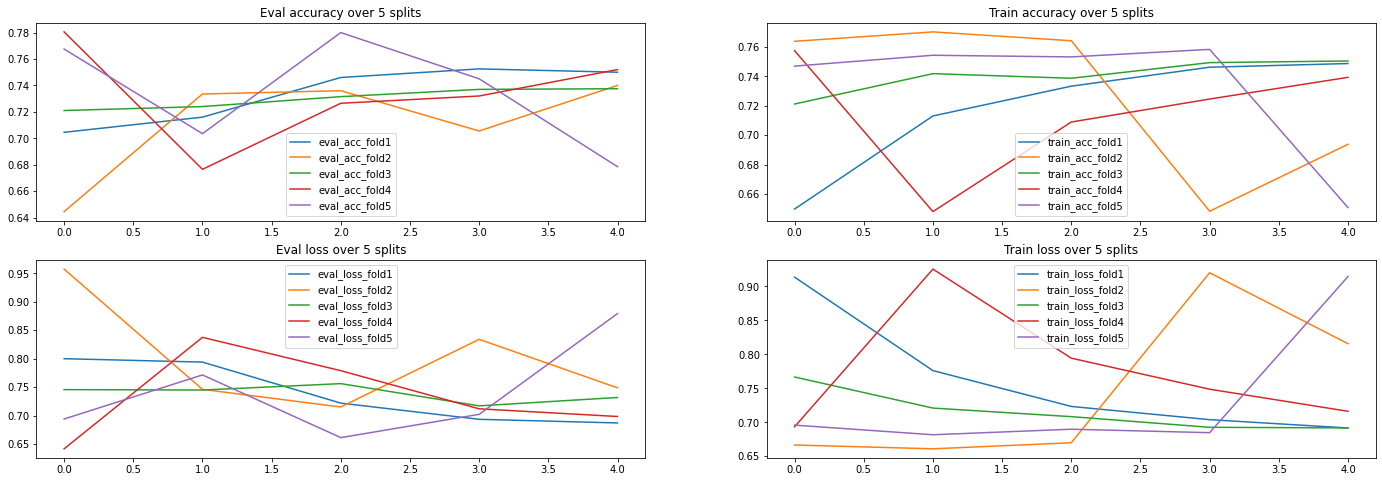

In [14]:
plt.figure(figsize=(24,8))
for i in range(k):
    plt.subplot(2,2,1)
    plt.plot(eval_accs[i], label=f'eval_acc_fold{i+1}')
    plt.subplot(2,2,2)
    plt.plot(train_accs[i], label=f'train_acc_fold{i+1}')
    
    plt.subplot(2,2,3)
    plt.plot(eval_loss[i], label=f'eval_loss_fold{i+1}')
    plt.subplot(2,2,4)
    plt.plot(train_loss[i], label=f'train_loss_fold{i+1}')


plt.subplot(2,2,1)
plt.title(f'Eval accuracy over {k} splits')
plt.legend()

plt.subplot(2,2,2)
plt.title(f'Train accuracy over {k} splits')
plt.legend()
plt.subplot(2,2,3)
plt.title(f'Eval loss over {k} splits')
plt.legend()

plt.subplot(2,2,4)
plt.title(f'Train loss over {k} splits')
plt.legend()

plt.show()

In [15]:
def predict(model, dataloader):
    model.eval()
    
    predictions, all_labels = [], []
    
    with torch.no_grad():
        for step, (images, labels) in tq.tqdm(enumerate(dataloader)):
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            loss = criterion(output, labels)

            preds= torch.argmax(output, dim=1)
            
            for pred in range(len(preds)):
                predictions.append(preds[pred].cpu())
                all_labels.append(labels[pred].cpu())

    return np.array(predictions), np.array(all_labels)


In [29]:
def test_models(models_path, dataloader):
    all_preds = []
    for i in range(5):
        model = Model().to(device)
        model_params = torch.load(os.path.join(models_path, f'model_{i}'))
        model.load_state_dict(model_params)
        predictions, all_labels = predict(model, val_dataloader)
        all_preds.append(predictions)
        print(f'accuracy: {torch.sum(torch.tensor(predictions) == torch.tensor(all_labels)) / len(dataloader.dataset):.3f}')
    return np.array(all_preds), all_labels

In [30]:
def ensemble_predictions(dataloader):
    ensembled_preds = []
    dataloader_len = len(dataloader.dataset)
    for i in range(dataloader_len):
        ensembled_preds.append(mode(all_preds[:, i])[0][0])

    print(f' ensembled acc: {(np.sum(ensembled_preds == all_labels) / dataloader_len)  *100:.1f}%')
    return ensembled_preds

In [31]:
all_preds, all_labels = test_models('/kaggle/working/', val_dataloader)
ensembled_preds = ensemble_predictions(val_dataloader)
print(classification_report(all_labels, ensembled_preds, target_names=classes_names))

0it [00:00, ?it/s]

accuracy: 0.699


0it [00:00, ?it/s]

accuracy: 0.724


0it [00:00, ?it/s]

accuracy: 0.689


0it [00:00, ?it/s]

accuracy: 0.713


0it [00:00, ?it/s]

accuracy: 0.657
 ensembled acc: 73.6%
              precision    recall  f1-score   support

       Coast       0.73      0.73      0.73       300
      Desert       0.85      0.87      0.86       300
      Forest       0.81      0.84      0.82       300
     Glacier       0.69      0.75      0.71       300
    Mountain       0.58      0.49      0.53       300

    accuracy                           0.74      1500
   macro avg       0.73      0.74      0.73      1500
weighted avg       0.73      0.74      0.73      1500

